# .NET Native Interop Performance Report

The following report evaluates the performance overhead of calling native C/C++ functions from managed C# code using the built-in interoperability capabilities of .NET known as P/Invoke. The report presents benchmarks of common interop scenarios that involve marshalling and passing values of primitive types, strings, arrays, and structures, in both directions (i.e. as both function parameters and return values or out parameters). Several ways of implementing the interop calls that have been added to the .NET framework throughout the years, namely the `DllImport` attribute, the source-generator backed `LibraryImport` attribute, and unmanaged function pointers are compared.

The benchmarks were executed on three .NET runtime versions as permitted by their respective supported feature sets: .NET Framework 4.8 (the last major version of the classic Windows-only runtime), .NET 6 (current LTS version of the portable .NET Core runtime) and the latest .NET 8 Preview.

## Related work

To our knowledge, there are not many comparable studies publicly available.

- This [article](https://dev.to/jeikabu/native-code-in-net-5-0-and-c-9-0-39h7) compares performance of a single interop call implemented via `DllImport`, managed delegates and function pointers on .NET 5. It shows `DllImport` and function pointers to have comparable performance with the latter having ~1ns lesser overhead. Managed delegates are roughly twice as slow.
- This [article](https://medium.com/p/c008e4da54db#8cec) compares two interop scenarios implemented via `DllImport`, delegates and directly emitting the `calli` IL [instruction](https://learn.microsoft.com/en-us/dotnet/api/system.reflection.emit.opcodes.calli?view=net-7.0). `DllImport` and the `calli`-based calls are shown to have similar performance with the latter being 1-2 ns faster. Delegates are almost two orders of magnitude slower in the measured scenarios. We opted not to include
- There are also older articles ([see](https://www.codeproject.com/Articles/253444/PInvoke-Performance) and [see](https://xinterop1.rssing.com/chan-55440957/latest.php))  containing benchmarking results focused on particular comparisons between P/Invoke and C++/CLI interop. 
- The .NET runtime team maintains a public repository of benchmarks used to measure changes in performance between runtime versions, however, the benchmark suite does not include almost any [interop-related scenarios](https://github.com/dotnet/performance/tree/ea52574a828cd8740a716978331f8ff8bfeeb472/src/benchmarks/micro/runtime/Interop).

## Overview of P/Invoke

In this section we provide a brief introduction to the .NET capabilities covered by the report. We describe the basic interop concepts and several APIs for declaring interop calls available in .NET under the umbrella term P/Invoke (short for *Platform Invocation Services*).

### Basic concepts and the `DllImport` attribute

The original P/Invoke API available since .NET 1.1 is using the `DllImport` attribute. This attribute is added to a declaration of a `static extern` (i.e. body-less) method like this:

```csharp
[DllImport("kernel32.dll")]
public static extern bool QueryPerformanceCounter(out long counter);
```

Such method can be called from the user code as a regular C# method. However, its implementation is generated during run-time based on the method signature and the configuration provided in the`DllImport` attribute (and several related attributes). For example, for the declaration above the built-in interop service of the .NET runtime generates code that tries to load the *kernel32.dll* native library (using the standard OS dynamic library resolution mechanism), get the address of the `QueryPerformanceCounter` function in the library and calls it using special Intermediate Language instruction `calli` for calling unmanaged callsites.

The actual execution process is more complex and involves resolving a series of IL stubs ([see](https://www.devops.lol/pinvoke-beyond-the-magic/)). However, this is beyond the scope of this report. What is more important is that, depending on the method signature and the `DllImport` configuration, the call may also include several safety related operations (see section TODO) and, more importantly, perform *marshalling* of the function's arguments and return value.

What happens during interop marshalling depends on whether the function's return value and arguments have blittable types or not. Data type is called **blittable** if it has the same representation in managed and unmanaged memory. Such types therefore do not need conversion when passed between .NET and native code. The following types are blittable:

- Primitive types such as `byte`, `int`, `float`, and `double`.
- Structs with fixed layout that contain only blittable fields (excluding array fields).
- One-dimensional arrays of blittable types.

Primitive blittable arguments and return values can be passed on the stack or in registers as-is (depending on the calling convention). In the case of reference types (or value types passed as `ref` parameters) being blittable means that instead of copying the value to the unmanaged memory, a pointer to the value's location in the managed memory can be passed to the native code. This saves one copy for *in* parameters and up to two copies for *out* parameters.

Conversely, **non-blittable** types are types whose representation needs to be appropriately converted during interop. These types include:

- `char` .NET characters are represented as 2-byte UTF-16 code units. By default, `DllImport` converts these to single-byte ANSI characters on Windows and UTF-8 characters on other platforms. The marshaller can be configured using attribute option to pass chars in the UTF-16 format.
- `string`  Strings need to be converted to null-terminated character arrays and passed as pointers. Similarly to individual characters, `DllImport` supports either UTF-16 or ANSI/UTF-8 strings.
- `bool`  Bools have historically multiple representations in different environments, ranging from 1 to 4 bytes, possibly with different mappings of numeric to boolean values. Attributes can be used to configure which format is used by the marshaller.
- Arrays other than one-dimensional arrays of blittable types. 
- Structures and classes containing any non-blittable fields, including array fields (with the exception of blittable arrays with compile-time constant size)

For convenience, the built-in `DllImport` marshaller handles several common scenarios involving non-blittable types automatically. This includes passing strings and bools (with optional configuration as mentioned) and also handling *out* parameters whose value needs to be provided back to the caller (such as the `out long counter` parameter of the `QueryPerformanceCounter` method above). In more complex cases (e.g. when passing non-blittable structures) the marshalling needs to be done by the user manually.

### Marshalling code generation and the `LibraryImport` attribute

Recently, the [`LibraryImport`](https://learn.microsoft.com/en-us/dotnet/standard/native-interop/pinvoke-source-generation) attribute has been added in .NET 7 as a replacement of `DllImport` for declaring P/Invoke methods. Apart from API changes that were made to remove the historical Windows-specific features and to unify the behavior on different platforms the most interesting difference is that the marshalling code (at least for non-trivial marshalling) is generated during compile-time instead of at run-time. This feature is enabled by the source generator mechanism which analyzes the user's code using the Roslyn compiler API and generates additional C# (not IL) code as part of the compilation (or on the fly in an IDE).

For example, when user declares a method such as:

```csharp
struct Timespec
{
    public long tv_sec;
    public long tv_nsec;
}

[LibraryImport("libc", EntryPoint = "clock_gettime")]
private static partial int GetTime(int clk_id, ref Timespec tp);
```

Then the interop source generator provides the implementation of the `partial` method similar to this (code modified for readability):

```csharp
private static partial int GetTime(int clk_id, ref Timespec tp)
{
    int __retVal;
    
    fixed (Timespec* __tp_native = &tp)
    {
        __retVal = __PInvoke(clk_id, __tp_native);
    }
    
    return __retVal;

    [DllImport("libc", EntryPoint = "clock_gettime")]
    static extern unsafe int __PInvoke(int clk_id, Timespec* tp);
}
```

Notice that the implementation internally still uses the `DllImport` attribute (and therefore the run-time interop service). However, the generated code handles non-trivial marshalling, in this case pinning the *out* parameter struct in memory and passing pointer to it to the native call. In this way the `LibraryImport` attribute converts the interop call to the which involves only passing primitive values on stack.

This has several ramifications for performance:

- Any inherent overhead of `DllImport` pertaining to calling the native method (marshalling excluded) also applies to `LibraryImport`.
- On the other hand, no run-time reflection and IL emission is needed to construct the marshalling code. This might lead to better cold start performance in particular.
- The pre-generated marshalling code can be inlined already by the C# compiler, not just the JIT compiler.
- The source generated interop is compatible with the Native AOT compilation available since .NET 7 (outside of the scope of this report).

### Unsafe function pointers

.NET 5 added another way of calling native functions using function pointers. This involves manually loading the native library and acquiring address to the exported function using the `NativeLibrary` API. The address (represented as an untyped `IntPtr` handle) can than be in an `unsafe` context cast to a typed function pointer using a special `delegate*` syntax. This pointer can be then invoked as a regular C# function.  For example:

```csharp
IntPtr kernelLib = NativeLibrary.Load("kernel32.dll");
IntPtr qpcPtr = NativeLibrary.GetExport(kernelLib, "QueryPerformanceCounter");
unsafe
{
    var qpc = (delegate* unmanaged<out long, bool>)qpcPtr;
    bool isSuccess = qpc(out long timestamp);
}
```

There is a very little documentation on the internal implementation of interop via function pointers. Apparently (see [discussion](https://github.com/dotnet/runtime/issues/46858#issuecomment-758810968)), the feature uses the same runtime interop service as traditional P/Invoke with `DllImport`, including basic marshalling capabilities. However, there is no support for marshalling most non-blittable types and the user is expected to convert any such values manually.

Without the knowledge of internals it is difficult to predict whether function pointers differ in performance from `DllImport` methods.

### Other methods

We omit use of managed delegates as these have shown to be significantly slower (see *Related work*) while not providing benefits over the other methods. We also not included implementation based on emitting the `calli` IL [instruction](https://learn.microsoft.com/en-us/dotnet/api/system.reflection.emit.opcodes.calli?view=net-7.0) during run-time as we wanted to focus on more standard .NET APIs intended for general developer audience.

### Interop settings

There are a few options available for `DllImport` and `LibraryImport` declarations that modify run-time behavior of the interop call. We evaluate effect of enabling or disabling these options in section TODO. Here we briefly describe their effect.

#### `SetLastError`

When the `SetLastError` attribute is added to the P/Invoke method declaration the marshaller retrieves the error code set by the called function (using `GetLastError` on Windows or `errno` on Linux) and stores it in a thread static variable for the managed code to use. Since .NET 5 the error variable is also cleared before each call. Enabling this option might incur minor performance overhead.

#### `SuppressUnmanagedCodeSecurity`

In the original .NET Framework each P/Invoke call involved a check for a permission to call unmanaged code (depending on the properties of the .NET assembly and the user that executed it). This check had to perform a stack walk to determine if the entire call chain conformed to the relevant security policy, causing a performance overhead for each interop call. This behavior can be disabled by adding the `SuppressUnmanagedCodeSecurity` attribute to the `DllImport` method declaration. The rewritten .NET Core [abandoned](https://learn.microsoft.com/en-us/dotnet/core/compatibility/core-libraries/5.0/code-access-security-apis-obsolete) the mechanism of Code Access Security and this attribute does nothing when executed on Core runtimes.

#### `SuppressGCTransition`

Each P/Invoke call causes the garbage collector to switch for the duration of the call from the default cooperative mode (where GC can only start once all threads reach a safe point) to the preemptive mode. This is done so that a blocking native call does not prevent GC for too long or indefinitely. Unsurprisingly, the mode switch incurs an performance overhead for each interop call.

The `SuppressGCTransition` attribute, which was previously used only internally in .NET base libraries and has been made available to users in .NET 5, allows to skip the GC mode transition. It should be noted, however, that this option is safe to use only for a restricted class of interop calls (see [list of conditions](https://learn.microsoft.com/en-us/dotnet/api/system.runtime.interopservices.suppressgctransitionattribute?view=net-7.0#remarks)).

## Benchmark platform

All tests were performed on a desktop computer with the following hardware  and software specifications.

**Hardware platform**

- CPU: Intel Core i5 10400F, 6 physical cores, 12 hyper-threads, running at fixed 2900 MHz frequency
- RAM: 64 GB DDR4, running at 3200 Mhz frequency
- Storage: Samsung 970 1 TB NVMe SSD

**Operation system**

- Windows 10 22H2 (Build 19045.3448)

**.NET SDKs and runtimes**

- .NET Framework 4.8
- .NET 6.0.414
- .NET 8.0.100-preview.7.23376.3

**C++ compiler**

- g++ 13.2.0 (MSYS distribution)
- Compiler options: `-std=c++17 -O2 -Wall`

## Plotting scripts

The following code is used throughout the report to plot the benchmark results.

In [1]:
import glob
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
import sys

color_map = dict(zip(
    ["Managed", "DllImport", "LibraryImport", "FuncPointers"],
    ["#79ccb3","#e9724d", "#d6d727", "#92cad1", ]
))

order_map = dict(zip(
    ["Managed", "DllImport", "LibraryImport", "FuncPointers"],
    [10, 20, 30, 40]
))


def load_results_file(run_dir: str) -> pd.DataFrame:
    results_dir = run_dir + "/results"
    file = glob.glob(results_dir + "/*measurements.csv")[0]
    df = pd.read_csv(file, delimiter=";")
    return df

def merge_results_files(root_dir: str) -> pd.DataFrame:
    files = glob.glob(root_dir + "*/results/*measurements.csv")
    print(files)
    result = pd.DataFrame()
    for file in files:
        df = pd.read_csv(file, delimiter=";")
        result = pd.concat([result, df])
    return result

def make_barplot(input_df: pd.DataFrame, title, unit, category = None, param = None, figsize = (14, 6)):
    category_df = input_df if category is None else input_df.query(f"Category == '{category}'")
    grouped_df = category_df.groupby(["Target_Type", "Target_Method", "Job_Runtime"])

    items = []
    methods = {
        ".NET 4.8": set(),
        ".NET 6.0": set(),
        ".NET 8.0": set(),
    }

    for keys, data in grouped_df:
        (type, method, runtime) = keys
        runtime_version = ".NET " + runtime.split(" ")[-1]
        case = f"{type}-{method}"
        methods[runtime_version].add(case)

        for val in data["Measurement_Value"].to_list():
            items.append({
                "Type": type,
                "Runtime": runtime_version,
                "Value": val if unit == "ns" else val / 1000.0 / 1000.0,
                "Order": order_map[type],
                "Color": color_map[type]
            })

    items.sort(key=lambda x: x["Order"])

    method_total = sum(map(len, methods.values()))
    method_ratios = list(map(lambda x: len(x) / method_total, methods.values()))

    input_df = pd.DataFrame(items)

    fig, ax = plt.subplots(1, 3, figsize=figsize, sharey=True, gridspec_kw={'width_ratios': method_ratios})
    fig.suptitle(title, fontsize=16, fontweight="bold")
    fig.supylabel(f"Mean execution time ({unit})", fontsize=12)

    for i, runtime in [(0, ".NET 4.8"), (1, ".NET 6.0"), (2, ".NET 8.0")]:
        _df = input_df[input_df.Runtime == runtime]
        sns.barplot(
            ax=ax[i],
            data=_df,
            x="Type", y="Value",
            palette=color_map,
            saturation=1.0
        )

        ax[i].bar_label(ax[i].containers[0], fmt='%.2f', label_type="center")
        ax[i].set_xlabel("")
        ax[i].set_ylabel("")
        ax[i].set_title(runtime, fontsize=12)

    plt.show()

## Experiments

We implemented the benchmarks using the [BenchmarkDotNet](https://github.com/dotnet/BenchmarkDotNet) library which is the [de-facto standard](https://github.com/dotnet/BenchmarkDotNet/network/dependents) for micro-benchmarking .NET code. The library provides API for declaring benchmark jobs (similarly to unit testing frameworks), handles benchmark execution and exporting results. When executing a benchmark in BenchmarkDotNet, the harness builds a separate .NET project for each combination of runtime environment, job definition and job parameters, and then performs a series of stages intended to ensure meaningful results based on steady state performance. In particular:

- *Pilot iterations* are used to select proper number of operations to do per actual benchmark iteration. The library uses configurable heuristics to compute this number (e.g. target iteration length or target error). We configured the library to select operation count in order to have results with **relative error (defined as <half of CI 99.9%> / Mean) less than `0.01`**.
- *Overhead iterations (warmup and workload)* are used to estimate overhead of the benchmark runner itself. Mean of this value is later subtracted from the actual results.
- *Warmup iterations* are used to warmup the actual workload method.
- *Workload iterations* are used to measure the actual benchmark results.
 
This worklfow describes the standard throughput benchmarks that comprise majority of this report. In section TODO we also try to evaluate the cold start performance. To do so, we execute benchmarks using configuration that disables the previously described stages. Instead it simply performs some number of separate launches, each with one iteration and one operation executed. No warmup or overhead estimation is done in this configuration. 

### Overhead baseline

- empty void functions
- compare with managed call

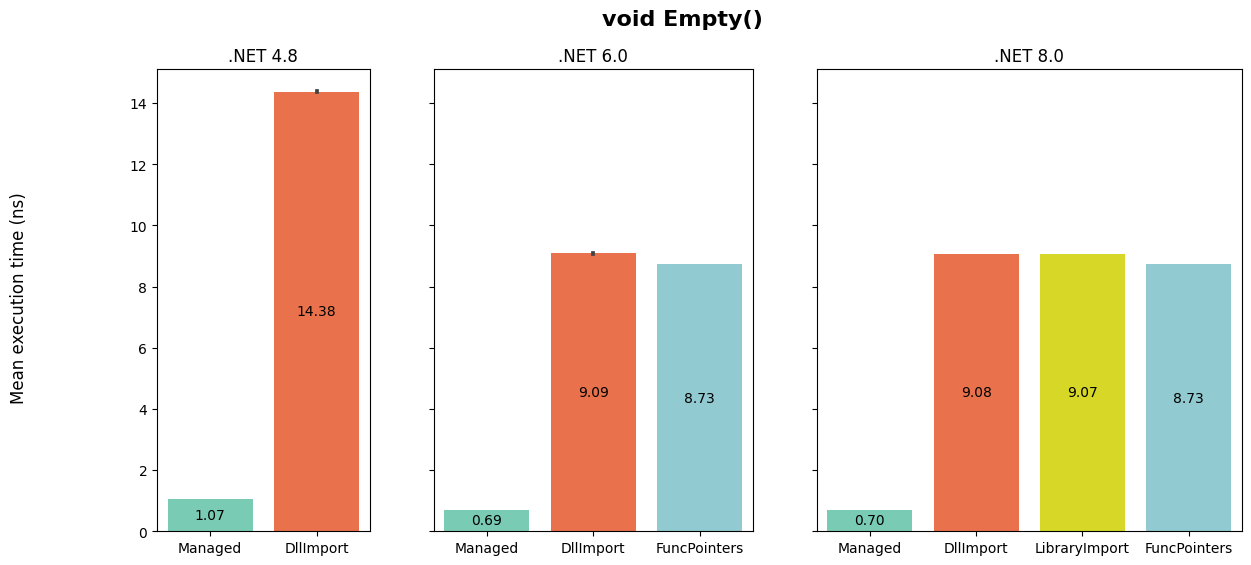

In [2]:
data = load_results_file("ReportData/Void_Empty_2023-09-21T00_21_17")
make_barplot(data, "void Empty()", "ns")

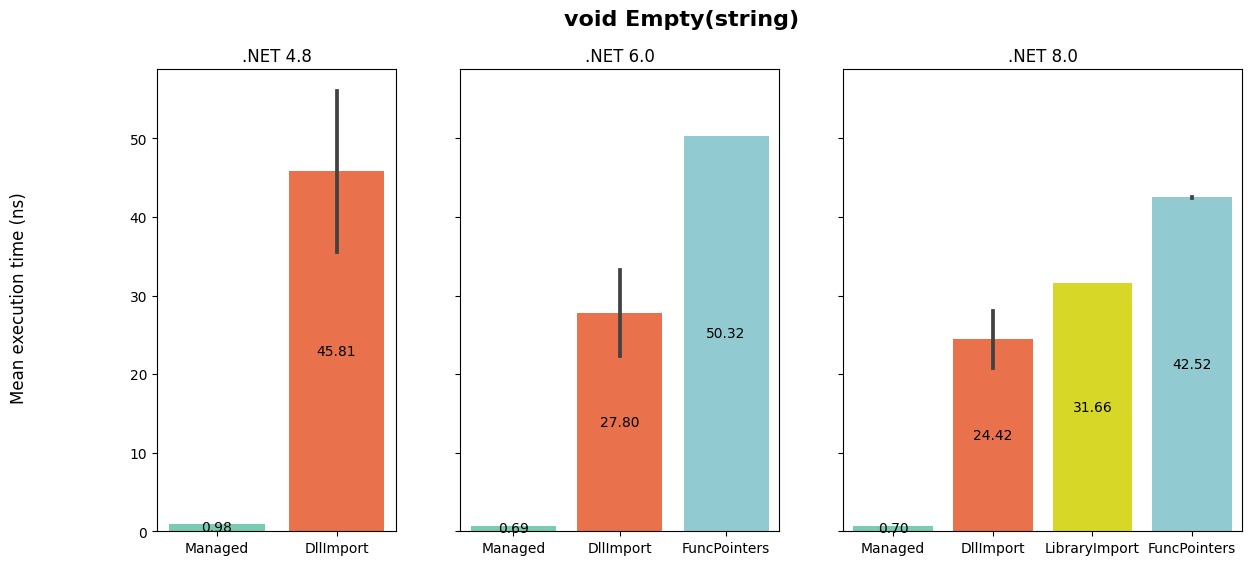

In [3]:
data = load_results_file("ReportData/Strings_Empty_In_2023-09-21T00_36_06")
make_barplot(data, "void Empty(string)", "ns")

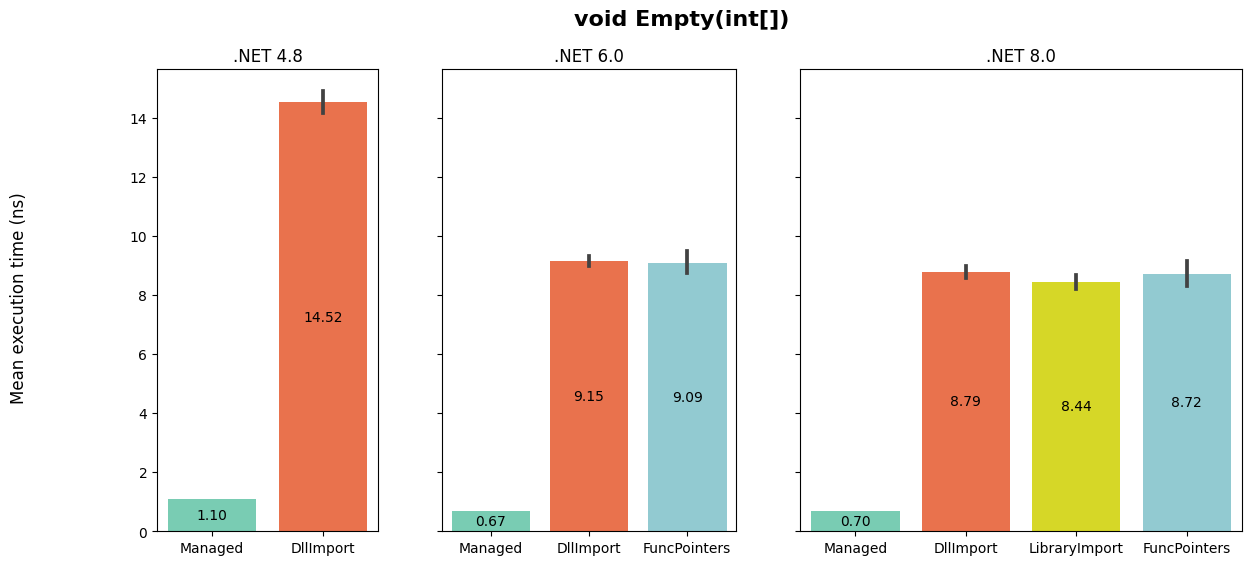

In [4]:
data = load_results_file("ReportData/Arrays_Empty_In_2023-09-21T00_31_56")
make_barplot(data, "void Empty(int[])", "ns")

### Effect of interop settings

#### `SetLastError`



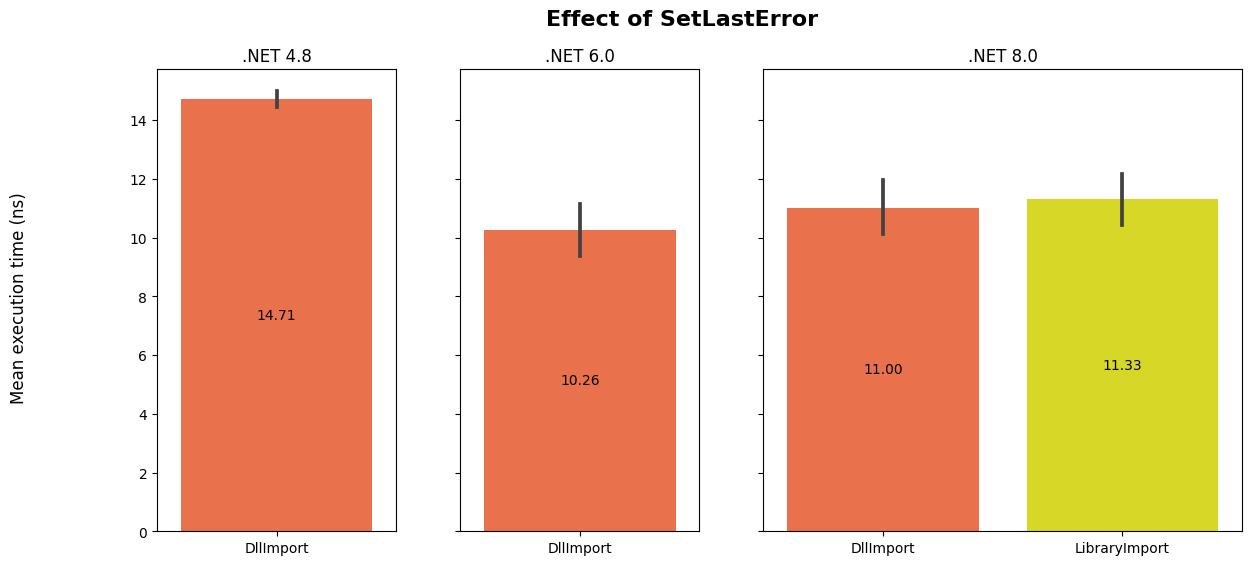

In [5]:
data = load_results_file("ReportData/SLE_2023-09-21T00_29_57")
make_barplot(data, "Effect of SetLastError", "ns")

#### `SuppressUnmanagedCodeSecurity`



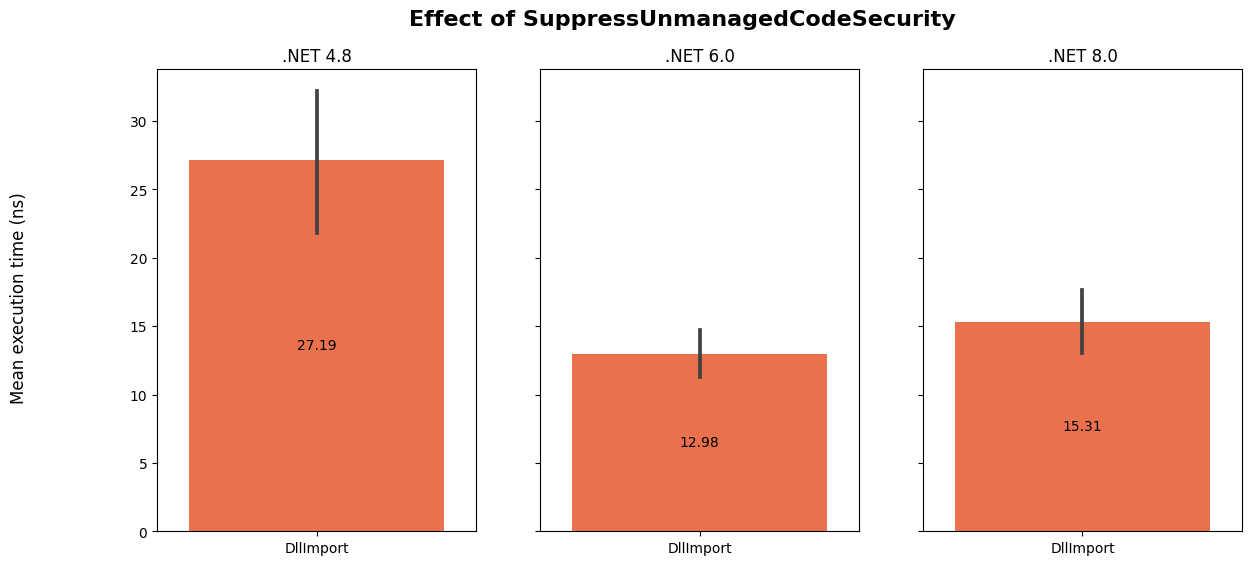

In [6]:
data = load_results_file("ReportData/SUCS_2023-09-21T00_26_11")
make_barplot(data, "Effect of SuppressUnmanagedCodeSecurity", "ns")

#### `SuppressGCTransition`

In [7]:
# data = load_results_file("ReportData/SGCT_2023-09-21T00_22_56")
# make_barplot(data, "Effect of SuppressGCTransition", "ns")

### Marshalling primitive types

- int input params
- int return values

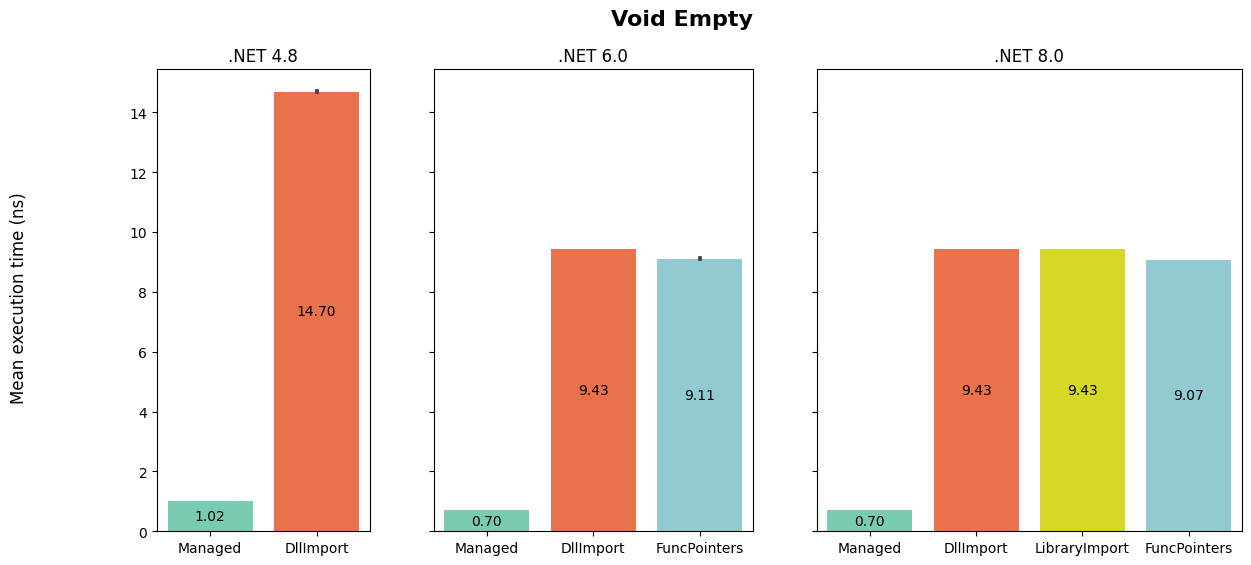

In [8]:
data = load_results_file("ReportData/Primitive_Int_Out_2023-09-21T00_38_07")
make_barplot(data, "Void Empty", "ns")

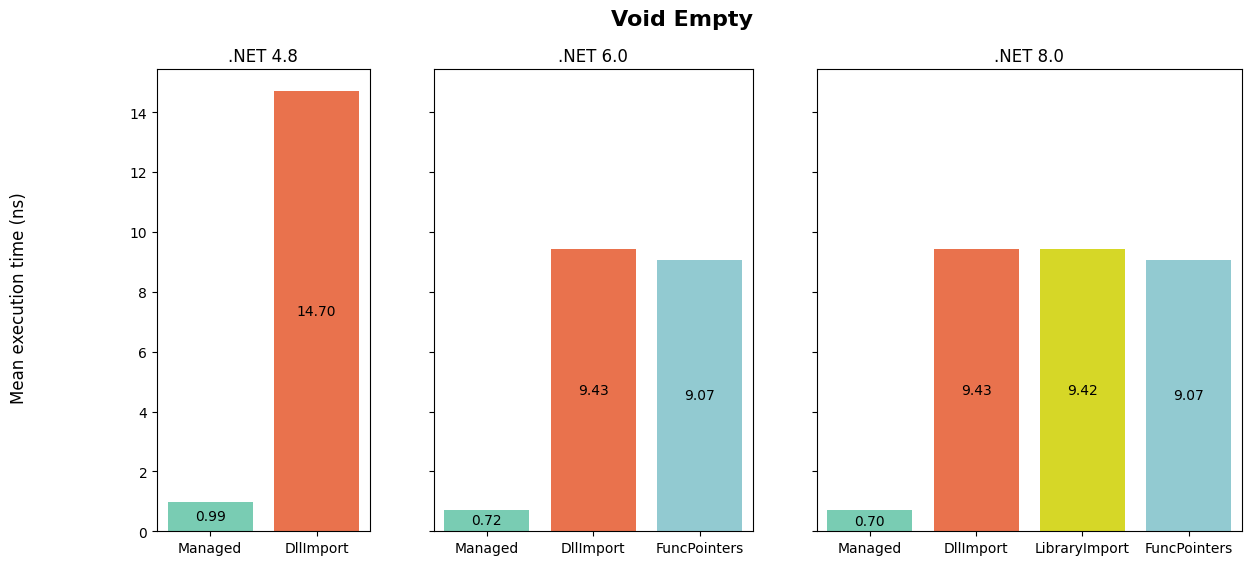

In [9]:
data = load_results_file("ReportData/Primitive_Int_InOut_2023-09-21T00_39_41")
make_barplot(data, "Void Empty", "ns")

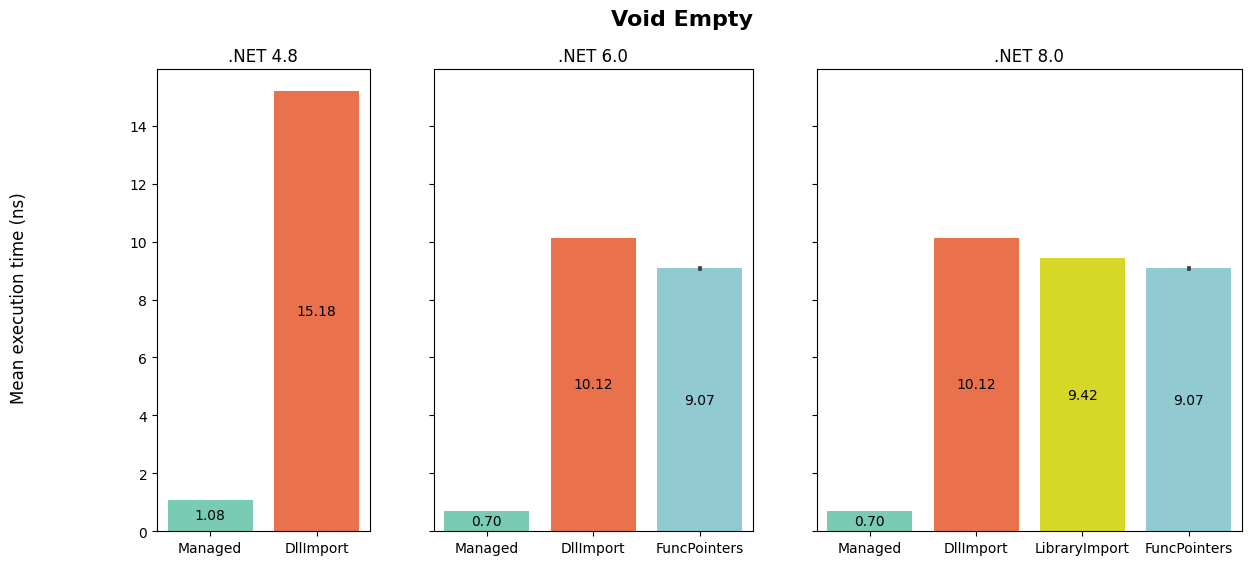

In [10]:
data = load_results_file("ReportData/Primitive_Bool_InOut_2023-09-21T00_41_18")
make_barplot(data, "Void Empty", "ns")

### Marshalling strings

- UTF8 conversion
- UTF16 pinning
- returning strings as out params

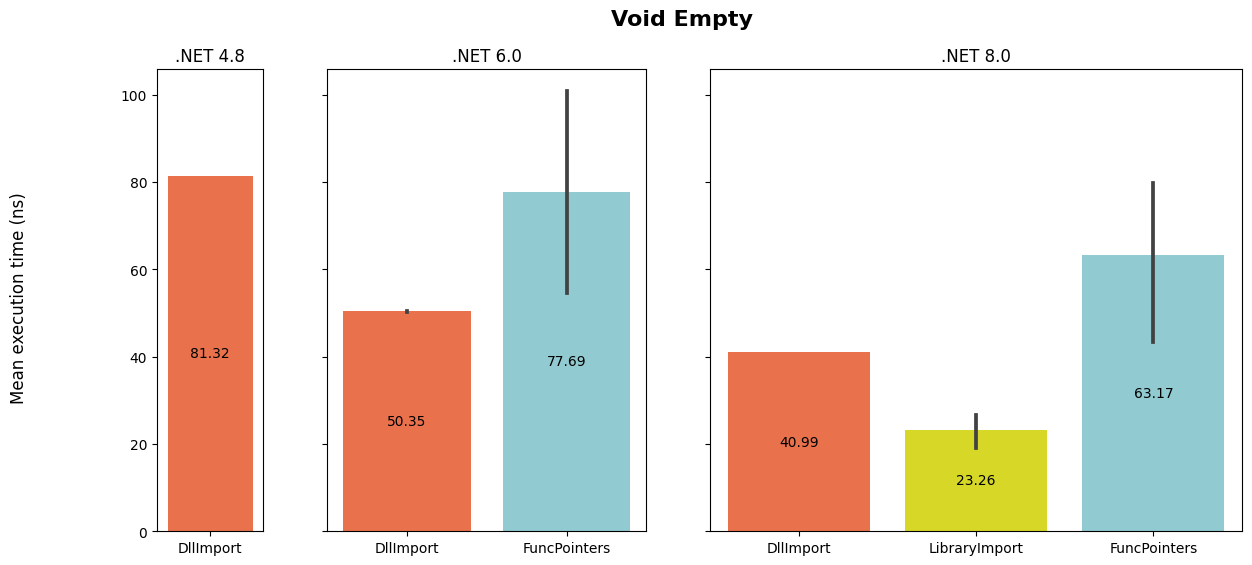

In [11]:
data = load_results_file("ReportData/Strings_In_2023-09-21T00_51_26")
make_barplot(data, "Void Empty", "ns")

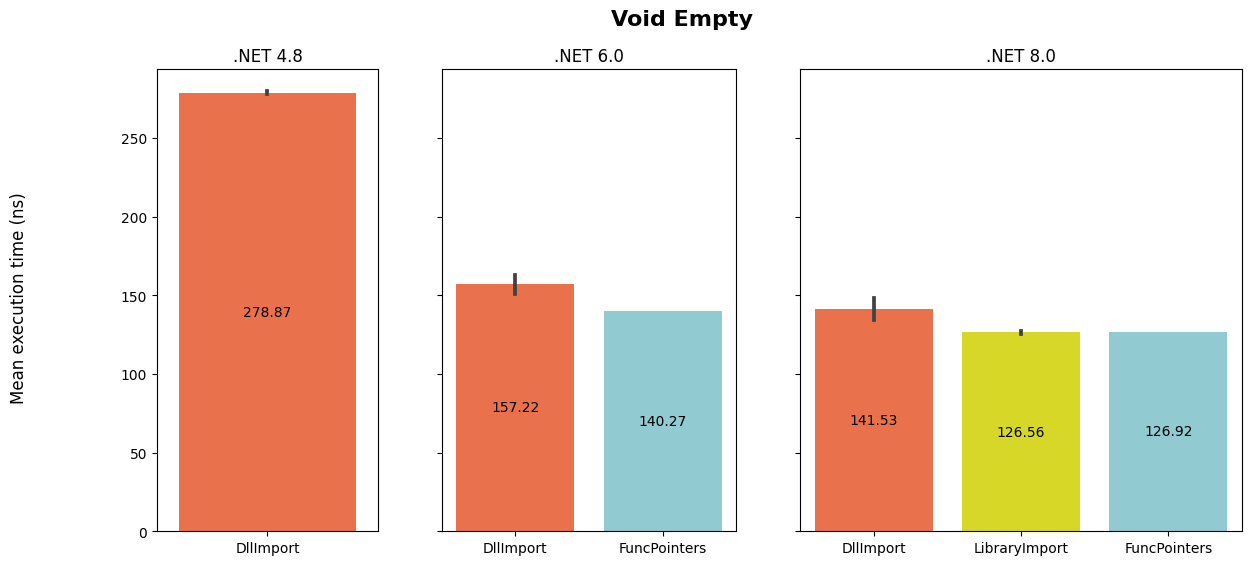

In [12]:
data = load_results_file("ReportData/Strings_InOut_2023-09-21T00_52_52")
make_barplot(data, "Void Empty", "ns")

### Marshalling arrays

- blittable arrays
- pinning managed arrays

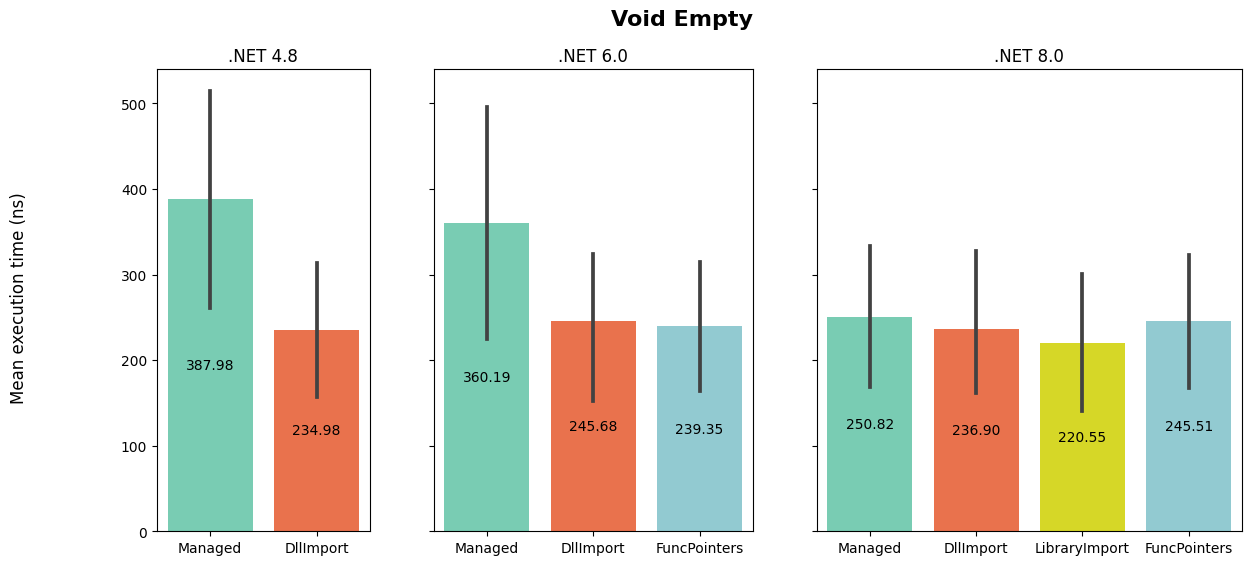

In [13]:
data = load_results_file("ReportData/Arrays_In_2023-09-21T00_42_56")
make_barplot(data, "Void Empty", "ns")

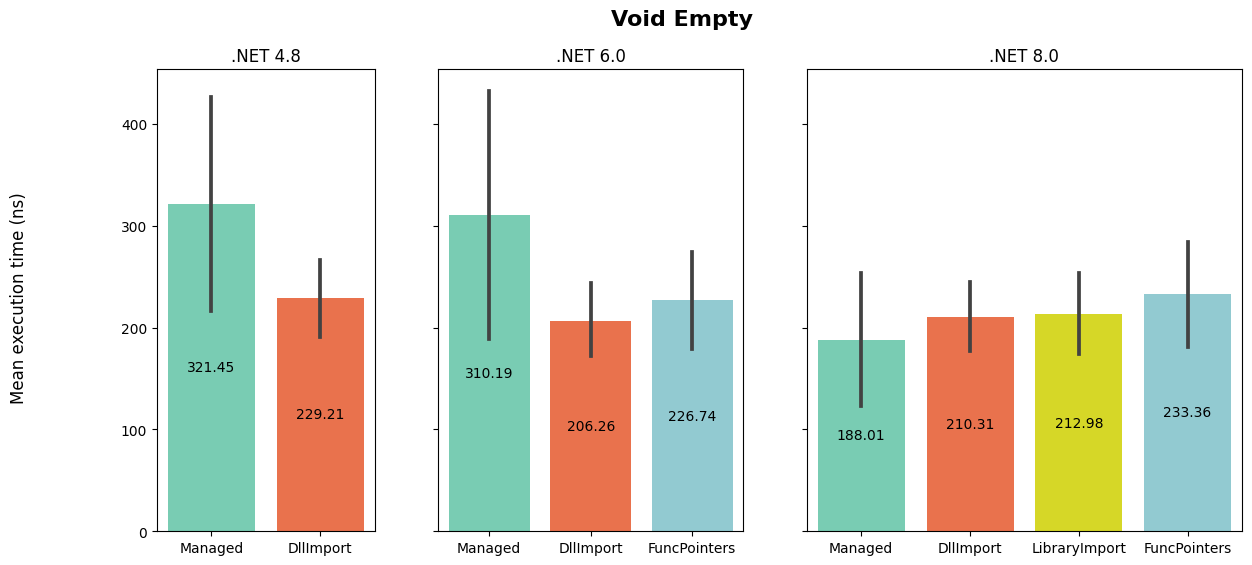

In [14]:
data = load_results_file("ReportData/Arrays_InOut_2023-09-21T00_45_32")
make_barplot(data, "Void Empty", "ns")

### Marshalling structures

- non-blittable fields
- manual marshalling
- custom marshaller

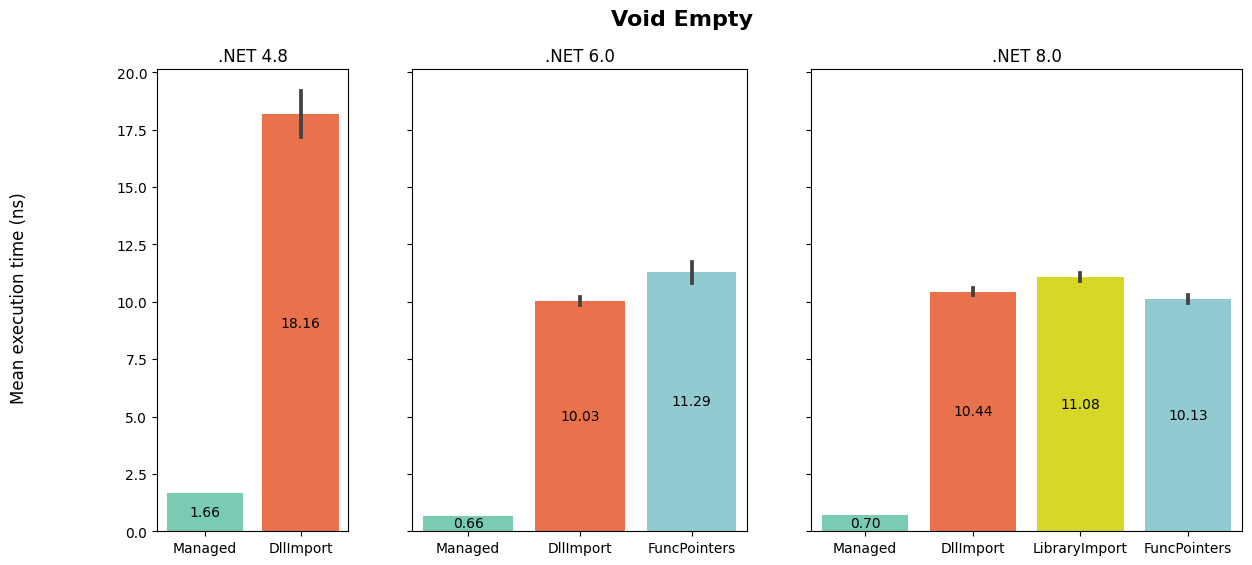

In [15]:
data = load_results_file("ReportData/Structs_Blittable_2023-09-21T00_54_51")
make_barplot(data, "Void Empty", "ns")

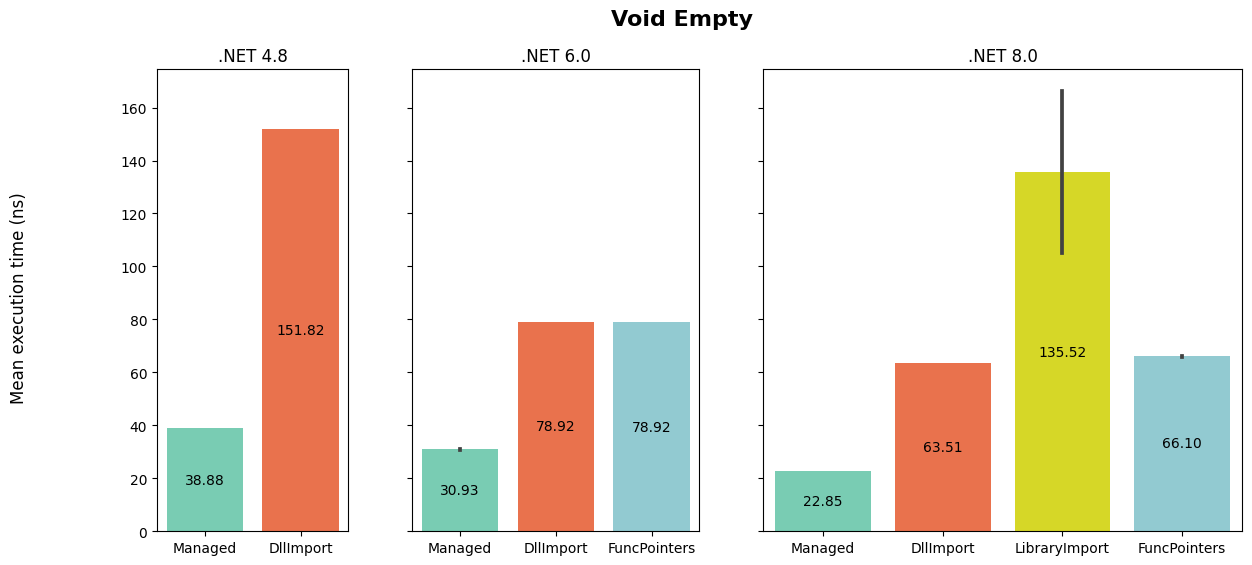

In [16]:
data = load_results_file("ReportData/Structs_NonBlittable_2023-09-21T00_57_59")
make_barplot(data, "Void Empty", "ns")

### Cold start performance

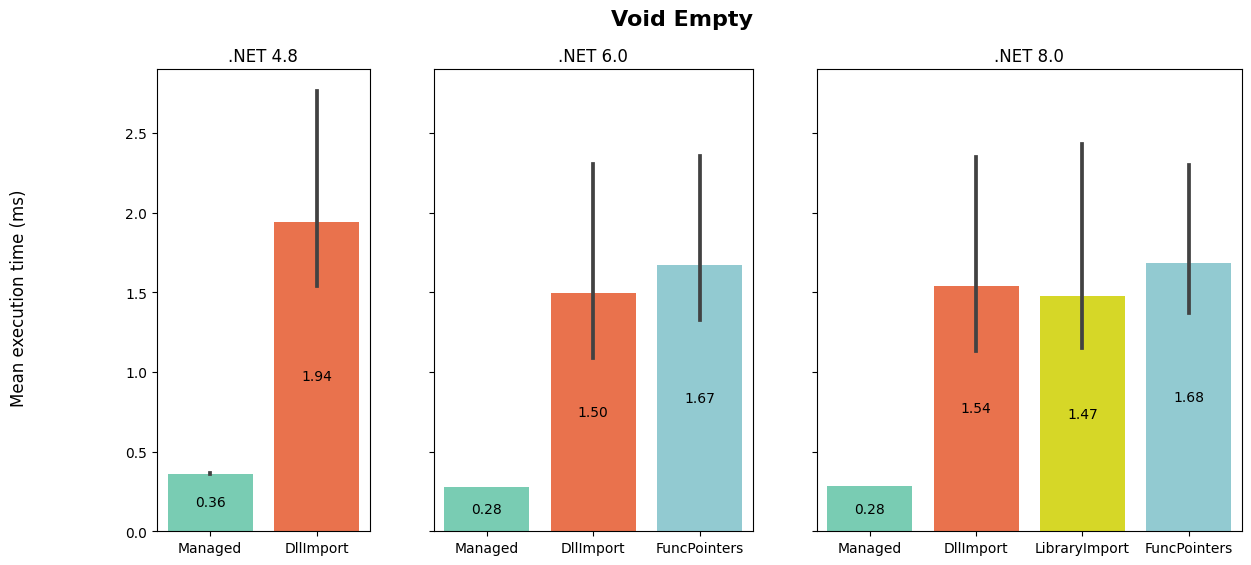

In [17]:
data = load_results_file("ReportData/CS_Void_Empty_2023-09-21T00_59_32")
make_barplot(data, "Void Empty", "ms")

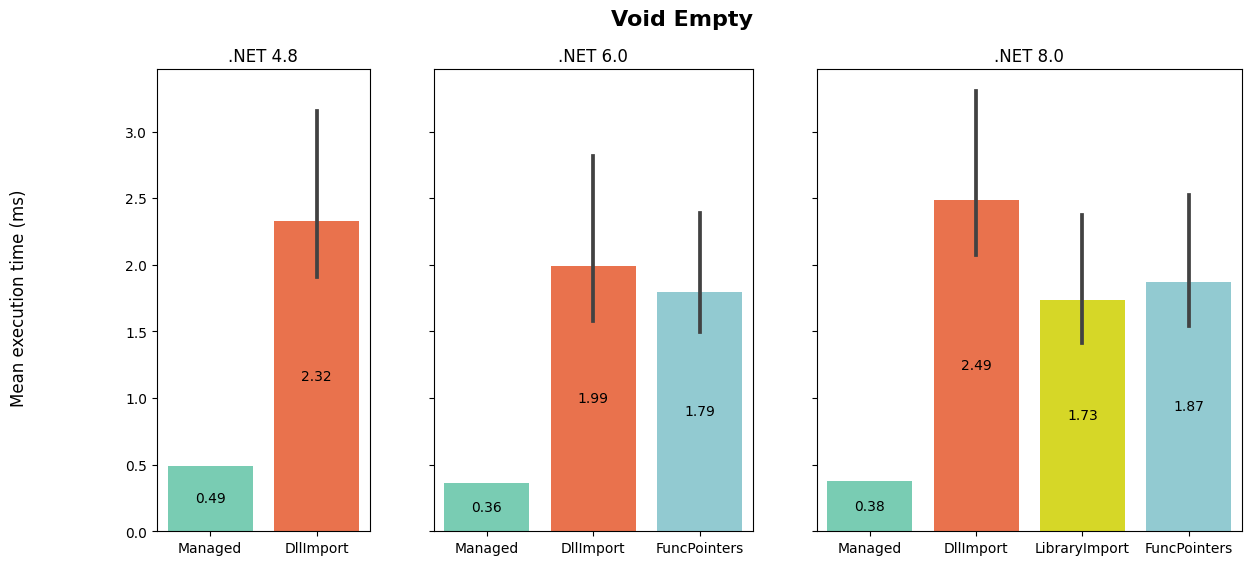

In [18]:
data = load_results_file("ReportData/CS_Strings_Empty_In_2023-09-21T01_03_17")
make_barplot(data, "Void Empty", "ms")

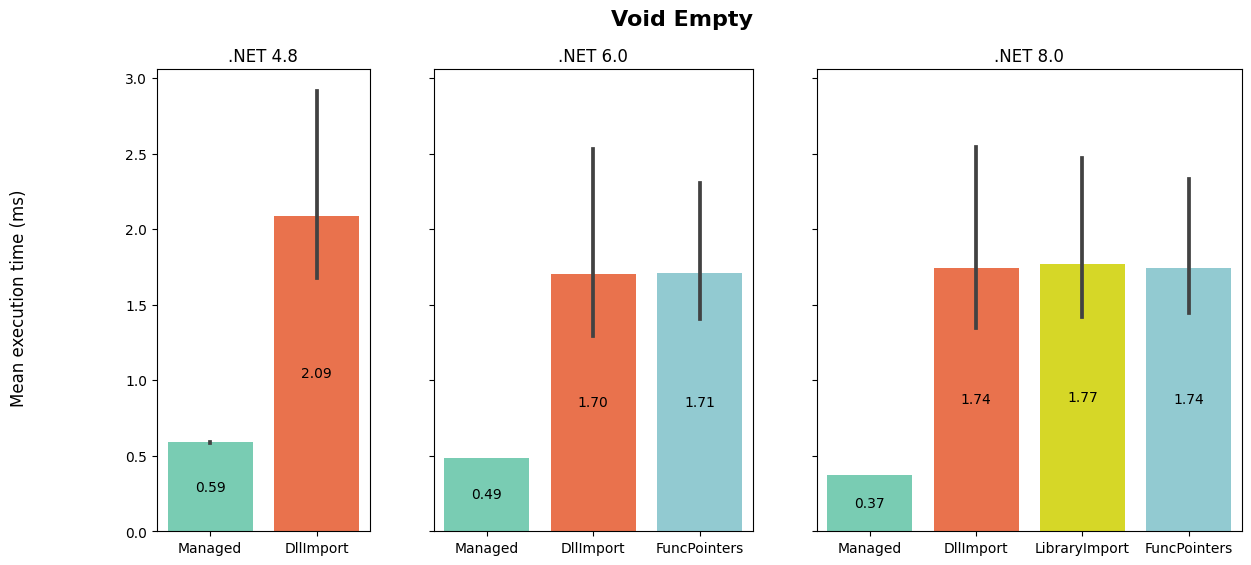

In [19]:
data = load_results_file("ReportData/CS_Arrays_InOut_2023-09-21T01_07_02")
make_barplot(data, "Void Empty", "ms")

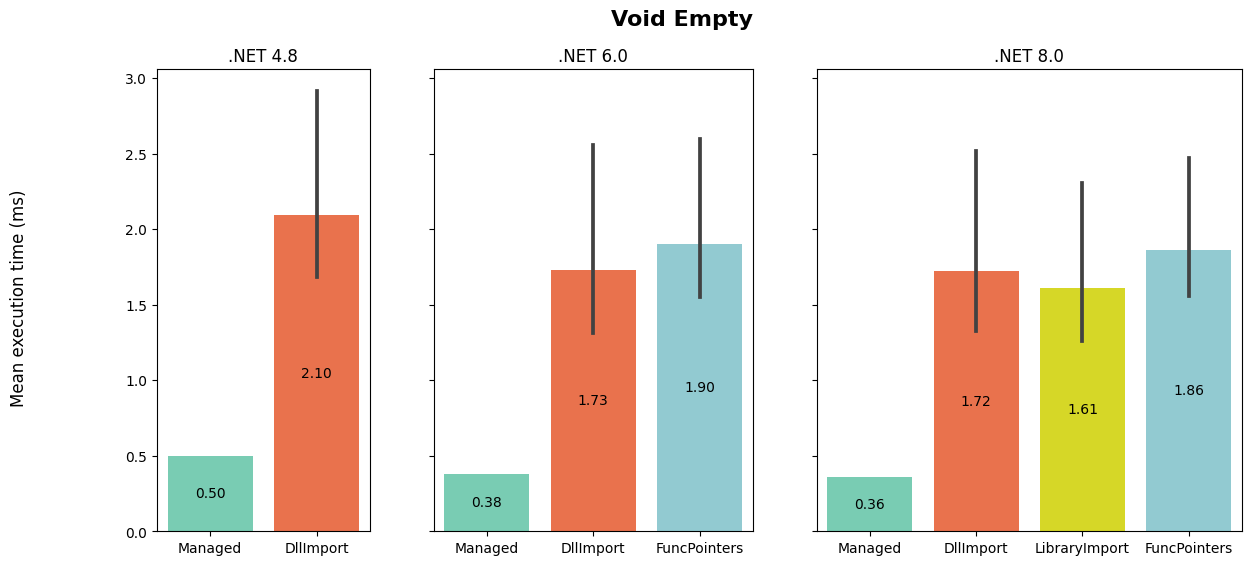

In [20]:
data = load_results_file("ReportData/CS_Structs_Blittable_2023-09-21T01_10_46")
make_barplot(data, "Void Empty", "ms")

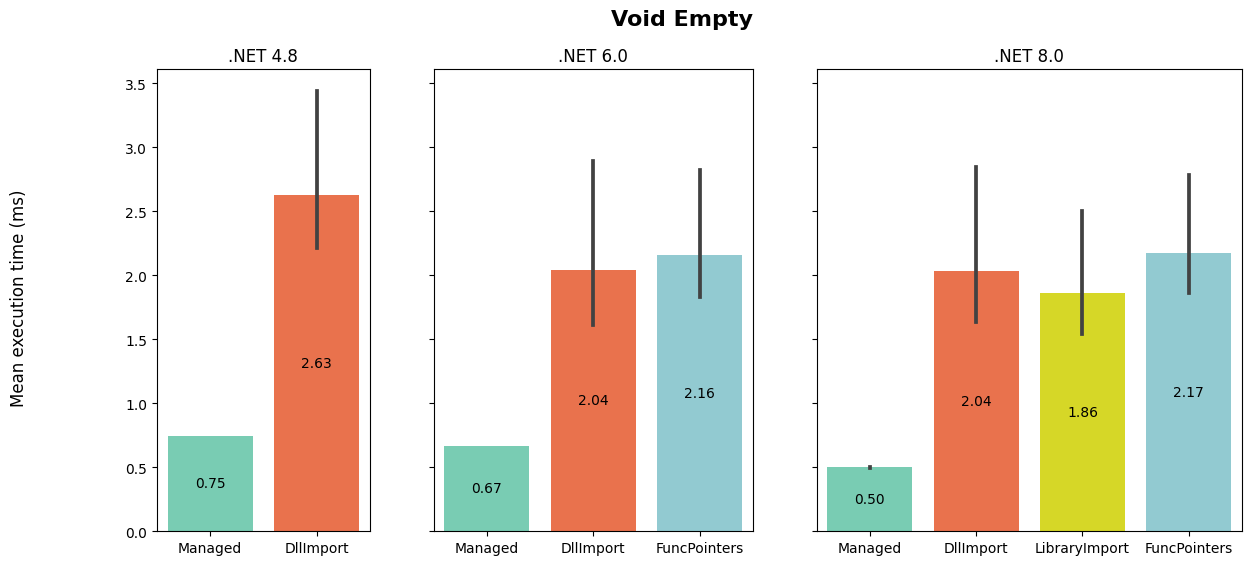

In [21]:
data = load_results_file("ReportData/CS_Structs_NonBlittable_2023-09-21T01_14_31")
make_barplot(data, "Void Empty", "ms")

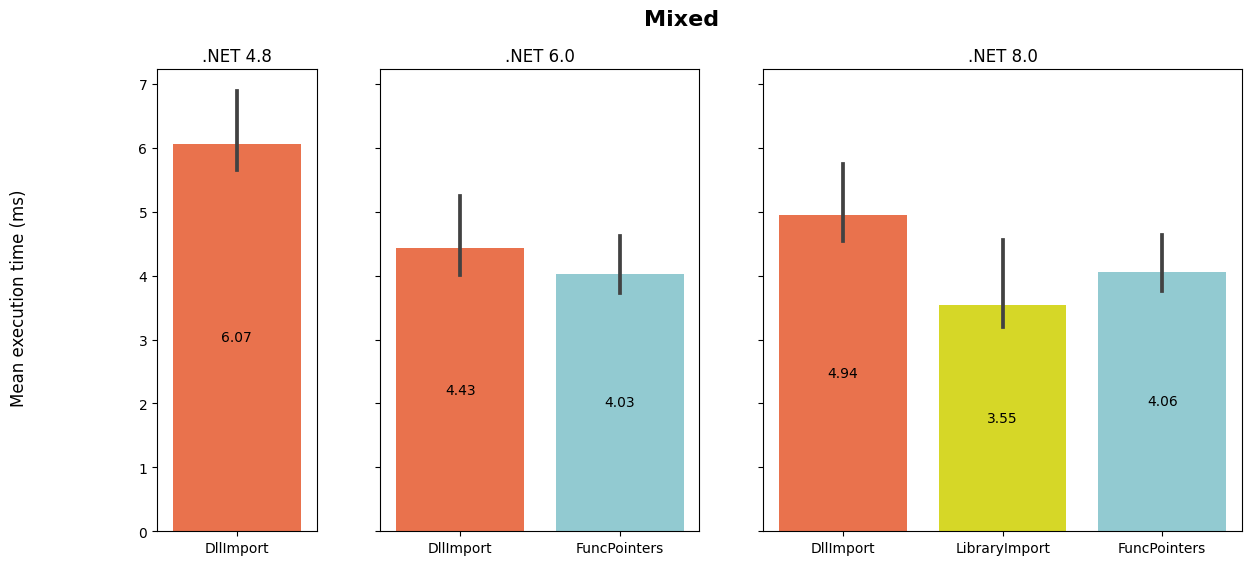

In [23]:
data = load_results_file("ReportData/CS_Mixed_2023-09-21T07_58_47")
make_barplot(data, "Mixed", "ms")

## Summary

#### Runtime versions

Net48 vs 6 vs 8

#### Interop methods

DllImport vs LibraryImport vs func pointers

#### Interop settings